In [1]:

# General imports.import pprint
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# ML-related imports
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Huggingface datasets.
from datasets import load_dataset

# Comparison of Bayesian Optimization Frameworks

In this notebook we are going to compare different bayesian optimization libraries against each other. To compare our results we will use [Huggingfaces spotify tracks dataset](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset) dataset. We performed a short EDA on this dataset in [notebooks/eda__spotify_tracks.ipynb](https://github.com/PeeteKeesel/bayes-opt-battle/blob/7fed8d739c1b02c84a1eff05c0d3a44cb108e686/notebooks/huggingface__spotify_tracks/eda__spotify_tracks.ipynb).  

## Global Settings

In [2]:
RANDOM_SEED = 42

In [3]:
dataset = load_dataset('maharshipandya/spotify-tracks-dataset')
print(f"Shape: {dataset.shape}")

Shape: {'train': (114000, 21)}


In [4]:
df = pd.DataFrame(dataset.get('train'))
print(f"Shape: {df.shape}")
df.info()

Shape: (114000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  

In [5]:
INT_FEATURES = df.select_dtypes(include=['int64', 'int32']).columns.tolist()
print(f"There are {len(INT_FEATURES)} int features in the dataset")

FLOAT_FEATURES = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
print(f"There are {len(FLOAT_FEATURES)} float features in the dataset")

FEATURES = INT_FEATURES + FLOAT_FEATURES
TARGET_PRIOR = 'popularity'

There are 6 int features in the dataset
There are 9 float features in the dataset


In [6]:
bins = np.arange(0, 101, 10)
labels = np.arange(0, len(bins)-1, 1)
assert len(bins) == len(labels)+1, f"len(bins) = {len(bins)} != {len(labels)}+1 = len(labels)"

df['popularity_bucket'] = pd.cut(df[TARGET_PRIOR], 
                                 bins=bins, 
                                 labels=labels, 
                                 include_lowest=True)

TARGET = 'popularity_bucket' 
df['popularity_bucket'].value_counts()     

0    23462
4    18904
2    17579
3    15570
5    14200
1    10715
6     8724
7     3892
8      886
9       68
Name: popularity_bucket, dtype: int64

In [7]:
def predict_and_summarize(X_train_scaled,
                          X_test_scaled, 
                          y_train, 
                          y_test,
                          clf,
                          model_type):

    y_pred_train = clf.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, y_pred_train)
    train_prec = precision_score(y_train, y_pred_train, average='macro', zero_division=0)
    train_rec = recall_score(y_train, y_pred_train, average='macro', zero_division=0)
    train_f1 = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

    y_pred = clf.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, y_pred)
    test_prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    test_rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"""
    Performance Results : {model_type} 
    ========================================
                    {'Train':<10}{'Test':<10}
        Accuracy  : {train_acc:<10.4f}{test_acc:<10.4f}
        Precision : {train_prec:<10.4f}{test_prec:<10.4f}
        Recall    : {train_rec:<10.4f}{test_rec:<10.4f}
        F1-Score  : {train_f1:<10.4f}{test_f1:<10.4f}
    """)

    return {'y_pred_train': y_pred_train, 'y_pred_test': y_pred}

## Dataset Preparation

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], 
                                                    df[TARGET], 
                                                    test_size=0.15,
                                                    random_state=RANDOM_SEED,
                                                    stratify=df[TARGET])
print(f"""
Shapes
======
    train: {X_train.shape}
    test : {X_test.shape}      
""")


Shapes
    train: (96900, 15)
    test : (17100, 15)      



In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Bayesian Hyperparameter Optimization

Now we will tune the models hyperparameters using different libraries provided by Python.

We will use `Precision` as our optimization metric.

In [10]:
X_tra, X_val, y_tra, y_val = train_test_split(X_train,
                                              y_train, 
                                              test_size=0.2, 
                                              random_state=RANDOM_SEED,
                                              stratify=y_train)
print(f"""
Shapes
======
    train : {X_tra.shape}
    val   : {X_val.shape}
    test  : {X_test.shape}
""")


Shapes
    train : (77520, 15)
    val   : (19380, 15)
    test  : (17100, 15)



---

## `BayesianOptimization`

In [17]:
N_ITER = 5

In [19]:
accuracies_train, precisions_train, recalls_train, f1s_train = [], [], [], []
accuracies_val, precisions_val, recalls_val, f1s_val = [], [], [], []
accuracies_test, precisions_test, recalls_test, f1s_test = [], [], [], []

def objective(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=RANDOM_SEED
        ))
    ])
        
    pipeline.fit(X_train, y_train)

    y_pred_train = pipeline.predict(X_train)
    y_pred_val = pipeline.predict(X_val)
    y_test_pred = pipeline.named_steps['classifier'].predict(X_test_scaled)
    
    prec_train = precision_score(y_train, y_pred_train, average='macro', zero_division=0)
    prec_val = precision_score(y_val, y_pred_val, average='macro', zero_division=0)
    prec_test = precision_score(y_test, y_test_pred, average='macro', zero_division=0)

    precisions_train.append(prec_train)
    precisions_val.append(prec_val)
    precisions_test.append(prec_test)

    return prec_val

pbounds = {
    'n_estimators': (50, 300),
    'max_depth': (2, 15),
    'min_samples_split': (0.1, 1.0),
    'min_samples_leaf': (0.1, 1.0),
}

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=RANDOM_SEED,
)

start_time = time.time()

# Maximize the optimization function.
optimizer.maximize(init_points=1, n_iter=N_ITER)

elapsed_time = time.time() - start_time
elapsed_minutes, elapsed_seconds = int(elapsed_time // 60), int(elapsed_time % 60)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.02058   | 6.869     | 0.9556    | 0.7588    | 199.7     |
| 2         | 0.02058   | 11.4      | 0.7013    | 0.3006    | 65.97     |
| 3         | 0.02058   | 14.96     | 0.305     | 0.9839    | 299.4     |
| 4         | 0.2791    | 2.835     | 0.176     | 0.2263    | 50.11     |
| 5         | 0.02058   | 14.62     | 0.7386    | 0.9945    | 143.5     |
| 6         | 0.02058   | 8.13      | 0.2444    | 0.8218    | 74.13     |


In [32]:
# The searched optimal parameters.
best_params = optimizer.max.get('params')

# Create the pipeline with the searched optimal parameters.
best_rfc = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=int(best_params['n_estimators']),
        max_depth=int(best_params['max_depth']),
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=RANDOM_SEED,
    ))
])

# Train the final model on the searched optimal parameters.
best_rfc.fit(X_train_scaled, y_train)

# Train metrics.
y_train_pred = best_rfc.predict(X_train_scaled)
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred, average='macro', zero_division=0)
train_rec = recall_score(y_train, y_train_pred, average='macro', zero_division=0)
train_f1 = f1_score(y_train, y_train_pred, average='macro', zero_division=0)

# Test metrics.
y_test_pred = best_rfc.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
test_rec = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print(f"""
BayesianOptimization Results
============================
                {'Train':<10}{'Test':<10}{'Delta(train,test)':<20}
    Accuracy  : {train_acc:<10.4f}{test_acc:<10.4f}{test_acc-train_acc:10.4f}
    Precision : {train_prec:<10.4f}{test_prec:<10.4f}{test_prec-train_prec:10.4f}
    Recall    : {train_rec:<10.4f}{test_rec:<10.4f}{test_rec-train_rec:10.4f}
    F1-Score  : {train_f1:<10.4f}{test_f1:<10.4f}{test_f1-train_f1:10.4f}

Tuning time: {elapsed_minutes} min {elapsed_seconds} sec

Best parameters:
""")
pp = pprint.PrettyPrinter()
pp.pprint(best_params)


BayesianOptimization Results
                Train     Test      Delta(train,test)   
    Accuracy  : 0.4859    0.4874        0.0015
    Precision : 0.2789    0.2779       -0.0010
    Recall    : 0.2744    0.2753        0.0010
    F1-Score  : 0.2060    0.2066        0.0006

Tuning time: 0 min 23 sec

Best parameters:

{'max_depth': 2.8348728122371676,
 'min_samples_leaf': 0.17601450450786865,
 'min_samples_split': 0.22633410683210597,
 'n_estimators': 50.10900357679988}


#### Plots

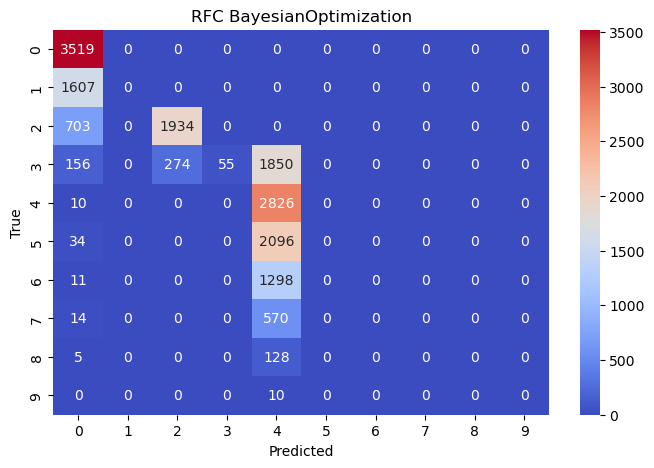

In [36]:
cm = confusion_matrix(y_test, y_test_pred)
class_labels = np.unique(y_test)

plt.figure(figsize=(8, 5))
sns.heatmap(cm, 
            annot=True, 
            cmap='coolwarm', 
            fmt='d', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RFC BayesianOptimization')

plt.savefig('../../imgs/spotify_tracks/rfc_cm_bayesianoptimization.png', dpi=300, bbox_inches='tight')

plt.show()

ValueError: x and y must have same first dimension, but have shapes (5,) and (6,)

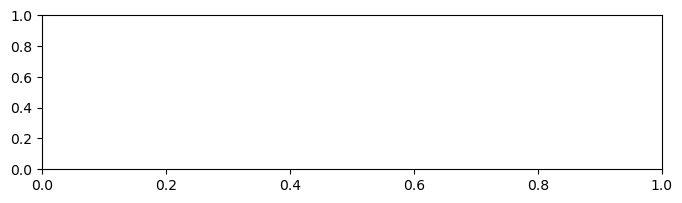

In [35]:
plt.figure(figsize=(8, 2))

plt.plot(np.arange(1, N_ITER+1, 1), precisions_train, label='Train', alpha=0.7, color='C0');
plt.plot(np.arange(1, N_ITER+1, 1), precisions_test, label='Test', alpha=0.7, color='C1');

plt.xlabel("# Trials");
plt.ylabel("Precision");
plt.legend();

plt.title("Optuna");
plt.show();